In [1]:
import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.applications import xception
from tensorflow.python.keras import optimizers, metrics
from sklearn.model_selection import train_test_split
import scipy.io
import numpy as np, pandas as pd
import PIL

/home/lolik111/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def auc(y_true, y_pred):
    value, update_op = tf.metrics.auc(y_true, y_pred)
    
    with tf.control_dependencies([update_op]):
        value = tf.identity(value, "auc_r")
        return value

base_model = xception.Xception(include_top=False, weights='imagenet', input_shape=(299, 299,3))
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(196, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

run_config = tf.estimator.RunConfig()
run_config = run_config.replace(keep_checkpoint_max=5, save_summary_steps=10)
model.compile(optimizer=optimizers.Adam(lr=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy', metrics.top_k_categorical_accuracy, metrics.mean_absolute_error, auc])
est = tf.keras.estimator.model_to_estimator(model, model_dir='x_input', config=run_config)

INFO:tensorflow:Using the Keras model from memory.
INFO:tensorflow:Using config: {'_model_dir': 'x_input', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc928febe48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [3]:
DATASET_FILE = 'cars_annos'
seed = 123
n_threads = 2
image_size=299
BATCH_SIZE=32

In [4]:
class ImageCoder(object):
    """Helper class that provides TensorFlow image coding utilities."""

    def __init__(self):
        self._sess = tf.Session()

        self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
        self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)
        self._to_raw = tf.image.encode_jpeg(self._decode_jpeg, format='rgb', quality=100)

    def decode_jpeg(self, image_data):
        image = self._sess.run(self._decode_jpeg,
                               feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image
    
    def from_file_jpeg(self, filename):
        with tf.gfile.FastGFile(filename, 'rb') as f:
            image_data = f.read()
        image = self.decode_jpeg(image_data)
        height = image.shape[0]
        width = image.shape[1]
        return image_data, height, width
    
    def raws(self, filename):
        with tf.gfile.FastGFile(filename, 'rb') as f:
            image_data = f.read()
        image = self._sess.run(self._decode_jpeg,
                               feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        height = image.shape[0]
        width = image.shape[1]
        if image.shape[2] == 3:
            return image_data, height, width
        else:
            image_data = self._sess.run(self._to_raw,
                               feed_dict={self._decode_jpeg_data: image_data})
            return image_data, height, width

In [5]:
def read_mat(fname):
    mat = scipy.io.loadmat('../data/' + fname +'.mat')
    df = pd.DataFrame(mat['annotations'][0])
    labels = pd.DataFrame(mat['class_names'][0])
    labels = labels.applymap((lambda x: x[0]))
    df = df.applymap((lambda x: x[0]))
    df.loc[:, df.columns != 'relative_im_path'] = \
        df.loc[:, df.columns != 'relative_im_path'].applymap((lambda x: x[0]))
    return df, labels

dataset, label_map = read_mat(DATASET_FILE)

coder = ImageCoder()

In [11]:
def load_and_show(df, coder, only_test = False):
    if not only_test:
        fname, xmin, ymin, xmax, ymax, label, _ = dataset.values[np.random.randint(0, dataset.shape[0]), :]
    else:
        _, X = train_test_split(dataset.values, test_size=0.3, random_state=seed, stratify=dataset.values[:, 5])
        fname, xmin, ymin, xmax, ymax, label, _ = X[np.random.randint(0, X.shape[0]), :]
    fname = '../data/' + fname
    img, height, width = coder.raws(fname)
    image = coder.decode_jpeg(img)
    op_crop = tf.image.crop_to_bounding_box(image, ymin, xmin, ymax - ymin, xmax - xmin)
    cropped_image = coder._sess.run(op_crop)
    print(label - 1, label_map.values[label - 1])   # label offset
    return cropped_image

def predict(cropped_image):
    op_net = tf.image.convert_image_dtype(cropped_image, dtype=tf.float32)
    op_net = tf.image.resize_images(op_net, [image_size, image_size],
                                                     method=0)
    op_net.set_shape([image_size, image_size, 3])
    op_net = tf.expand_dims(op_net, 0)
    image_to_net = coder._sess.run(op_net)

    one_input = tf.estimator.inputs.numpy_input_fn({'input_1': image_to_net}, batch_size=1, shuffle=False)
    gen = est.predict(one_input)
    results = list(gen)
    result = np.array(list(results[0].values()))
    res_label = np.argmax(result)
    res_text = label_map.values[res_label]
    print(res_label, res_text)
    return res_label

139 ['Hyundai Azera Sedan 2012']


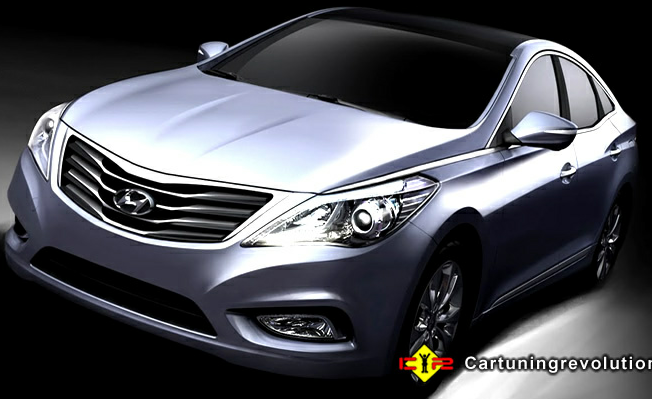

In [16]:
cropped_image = load_and_show(dataset, coder, only_test=True)
PIL.Image.fromarray(cropped_image)

In [17]:
predict(cropped_image)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from x_input/model.ckpt-4120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
139 ['Hyundai Azera Sedan 2012']


139